# DCGAN生成漫画头像





## DCGAN原理

DCGAN（深度卷积对抗生成网络，Deep Convolutional Generative Adversarial Networks）是GAN的直接扩展。不同之处在于，DCGAN会分别在判别器和生成器中使用卷积和转置卷积层。

它最早由Radford等人在论文[Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf)中进行描述。判别器由分层的卷积层、BatchNorm层和LeakyReLU激活层组成。输入是3x64x64的图像，输出是该图像为真图像的概率。生成器则是由转置卷积层、BatchNorm层和ReLU激活层组成。输入是标准正态分布中提取出的隐向量$z$，输出是3x64x64的RGB图像。

本案例将使用动漫头像数据集来训练一个生成式对抗网络，接着使用该网络生成动漫头像图片。


## 设置运行环境

由于资源限制，需开启性能优化模式，具体设置如下参数：

 max_device_memory="2GB" : 设置设备可用的最大内存为2GB。

 mode=mindspore.GRAPH_MODE : 表示在GRAPH_MODE模式中运行。

 device_target="Ascend" : 表示待运行的目标设备为Ascend。

 jit_config={"jit_level":"O2"} : 编译优化级别开启极致性能优化，使用下沉的执行方式。

 ascend_config={"precision_mode":"allow_mix_precision"} : 自动混合精度，自动将部分算子的精度降低到float16或bfloat16。

In [ ]:
import mindspore
mindspore.set_context(max_device_memory="2GB", mode=mindspore.GRAPH_MODE, device_target="Ascend",  jit_config={"jit_level":"O2"}, ascend_config={"precision_mode":"allow_mix_precision"})

## 数据准备与处理

首先我们将数据集下载到指定目录下并解压。示例代码如下：

In [1]:
from download import download

url = "https://download.mindspore.cn/dataset/Faces/faces.zip"

path = download(url, "./faces", kind="zip", replace=True)


file_sizes: 100%|████████████████████████████| 288M/288M [00:23<00:00, 12.4MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./faces


下载后的数据集目录结构如下：

```text
./faces/faces
├── 0.jpg
├── 1.jpg
├── 2.jpg
├── 3.jpg
├── 4.jpg
    ...
├── 70169.jpg
└── 70170.jpg
```

### 数据处理

首先为执行过程定义一些输入：

In [2]:
batch_size = 4          # 批量大小
image_size = 64           # 训练图像空间大小
nc = 3                    # 图像彩色通道数
nz = 100                  # 隐向量的长度
ngf = 64                  # 特征图在生成器中的大小
ndf = 64                  # 特征图在判别器中的大小

定义`create_dataset_imagenet`函数对数据进行处理和增强操作。

In [3]:
import numpy as np
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import mindspore as ms

def create_dataset_imagenet(dataset_path):
    """数据加载"""
    dataset = ds.ImageFolderDataset(dataset_path,
                                    num_parallel_workers=4,
                                    shuffle=True,
                                    decode=True)

    # 数据增强操作
    transforms = [
        vision.Resize(image_size),
        vision.CenterCrop(image_size),
        vision.HWC2CHW(),
        lambda x: ((x / 255).astype("float32"))
    ]

    # 数据映射操作
    dataset = dataset.project('image')
    dataset = dataset.map(transforms, 'image')

    # 批量操作
    dataset = dataset.batch(batch_size)
    return dataset

dataset = create_dataset_imagenet('./faces')

[WARNING] ME(26746:281473703608336,MainProcess):2024-09-09-15:09:12.271.424 [mindspore/run_check/_check_version.py:357] MindSpore version 2.2.14 and Ascend AI software package (Ascend Data Center Solution)version 7.0 does not match, the version of software package expect one of ['7.1']. Please refer to the match info on: https://www.mindspore.cn/install
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
[WARNING] ME(26746:281473703608336,MainProcess):2024-09-09-15:09:14.543.254 [mindspore/run_check/_check_version.py:375] MindSpore version 2.2.14 and "te" wheel pack

通过`create_dict_iterator`函数将数据转换成字典迭代器，然后使用`matplotlib`模块可视化部分训练数据。

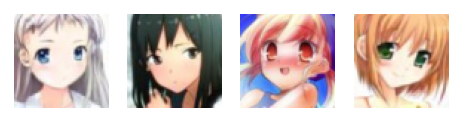

In [4]:
import matplotlib.pyplot as plt

def plot_data(data):
    # 可视化部分训练数据
    plt.figure(figsize=(4, 1), dpi=140)
    for i, image in enumerate(data[0][:4], 1):
        plt.subplot(1, 4, i)
        plt.axis("off")
        plt.imshow(image.transpose(1, 2, 0))
    plt.show()

sample_data = next(dataset.create_tuple_iterator(output_numpy=True))
plot_data(sample_data)

## 构造网络

当处理完数据后，就可以来进行网络的搭建了。按照DCGAN论文中的描述，所有模型权重均应从`mean`为0，`sigma`为0.02的正态分布中随机初始化。

### 生成器

生成器`G`的功能是将隐向量`z`映射到数据空间。由于数据是图像，这一过程也会创建与真实图像大小相同的 RGB 图像。在实践场景中，该功能是通过一系列`Conv2dTranspose`转置卷积层来完成的，每个层都与`BatchNorm2d`层和`ReLu`激活层配对，输出数据会经过`tanh`函数，使其返回`[-1,1]`的数据范围内。

DCGAN论文生成图像如下所示：

![dcgangenerator](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0/tutorials/application/source_zh_cn/cv/images/dcgan.png)

> 图片来源：[Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf).

我们通过输入部分中设置的`nz`、`ngf`和`nc`来影响代码中的生成器结构。`nz`是隐向量`z`的长度，`ngf`与通过生成器传播的特征图的大小有关，`nc`是输出图像中的通道数。

以下是生成器的代码实现：

In [5]:
from mindspore import nn, ops
from mindspore.common.initializer import Normal

weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

class Generator(nn.Cell):
    """DCGAN网络生成器"""

    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.SequentialCell(
            nn.Conv2dTranspose(nz, ngf * 8, 4, 1, 'valid', weight_init=weight_init),
            nn.BatchNorm2d(ngf * 8, gamma_init=gamma_init),
            nn.ReLU(),
            nn.Conv2dTranspose(ngf * 8, ngf * 4, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf * 4, gamma_init=gamma_init),
            nn.ReLU(),
            nn.Conv2dTranspose(ngf * 4, ngf * 2, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf * 2, gamma_init=gamma_init),
            nn.ReLU(),
            nn.Conv2dTranspose(ngf * 2, ngf, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf, gamma_init=gamma_init),
            nn.ReLU(),
            nn.Conv2dTranspose(ngf, nc, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.Tanh()
            )

    def construct(self, x):
        return self.generator(x)

generator = Generator()

### 判别器

如前所述，判别器`D`是一个二分类网络模型，输出判定该图像为真实图的概率。通过一系列的`Conv2d`、`BatchNorm2d`和`LeakyReLU`层对其进行处理，最后通过`Sigmoid`激活函数得到最终概率。

DCGAN论文提到，使用卷积而不是通过池化来进行下采样是一个好方法，因为它可以让网络学习自己的池化特征。

判别器的代码实现如下：

In [6]:
class Discriminator(nn.Cell):
    """DCGAN网络判别器"""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.SequentialCell(
            nn.Conv2d(nc, ndf, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf * 2, gamma_init=gamma_init),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf * 4, gamma_init=gamma_init),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf * 8, gamma_init=gamma_init),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 8, 1, 4, 1, 'valid', weight_init=weight_init),
            )
        self.adv_layer = nn.Sigmoid()

    def construct(self, x):
        out = self.discriminator(x)
        out = out.reshape(out.shape[0], -1)
        return self.adv_layer(out)

discriminator = Discriminator()

## 结果展示

下面我们通过加载生成器网络模型参数文件来生成图像，代码如下：

In [ ]:
# download ckpt
dcgan_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-online-infer/10-DCGAN/generator.ckpt"
path = "./generator.ckpt"
ckpt_path = download(dcgan_url, path, replace=True)

# 从文件中获取模型参数并加载到网络中
mindspore.load_checkpoint(ckpt_path, generator)

fixed_noise = ops.standard_normal((batch_size, nz, 1, 1))
img64 = generator(fixed_noise).transpose(0, 2, 3, 1).asnumpy()

fig = plt.figure(figsize=(4, 1), dpi=120)
images = []
images.append(np.concatenate((img64[0: 4]), axis=1))
img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
plt.axis("off")
plt.imshow(img)
plt.show()